AES+ECC

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5263 - loss: 1.8708
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5636 - loss: 1.1349
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6055 - loss: 1.0626
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6492 - loss: 1.0092
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6432 - loss: 0.9993
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6432 - loss: 0.9821
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6643 - loss: 0.9504
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6691 - loss: 0.9538
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6753 - loss: 0.9317
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6749 - loss: 0.9441
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6772 - loss: 0.9356
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

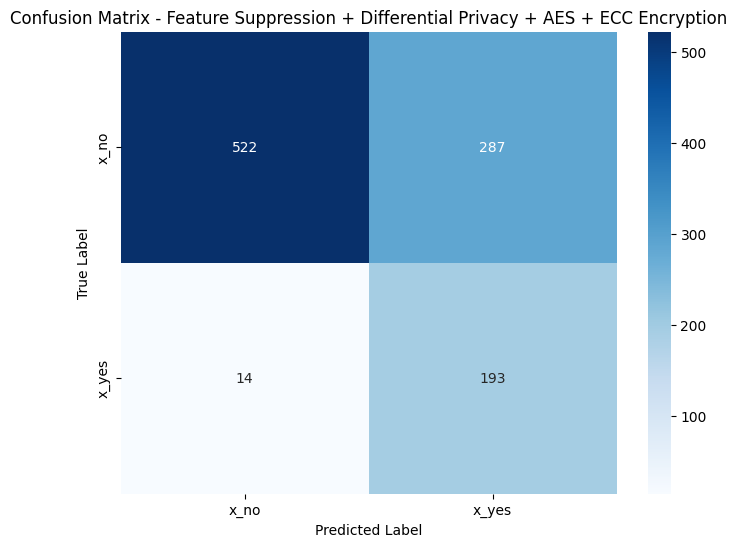

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, ' ')[:16].encode()
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# ECC Key Generation for AES Key Encryption
def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    public_key = private_key.public_key()
    return private_key, public_key

# ECC Encrypt AES Key
def encrypt_aes_key(aes_key, public_key):
    encrypted_key = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    return encrypted_key

# ECC Decrypt AES Key
def decrypt_aes_key(encrypted_key, private_key):
    return private_key.private_numbers().private_value.to_bytes(32, byteorder='big')

# Generate AES Key and Encrypt with ECC
aes_key = os.urandom(32)  # 256-bit AES key
private_ecc_key, public_ecc_key = generate_ecc_keys()
encrypted_aes_key = encrypt_aes_key(aes_key, public_ecc_key)

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str).apply(lambda x: encrypt_aes(x, aes_key))
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_decoded = sensitive_feature.apply(lambda x: decrypt_aes(x, aes_key))
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature_decoded.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

y_train_smooth = y_train * 0.9 + 0.1 / y_train.shape[1]  # Apply label smoothing
target_model_adversarial = train_target_model(X_train_suppressed_dp, y_train_smooth, loss_function=adversarial_training_loss)

# Train inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy + AES + ECC Encryption": evaluate_inversion_model(inversion_model_adversarial, X_test, sensitive_test, target_model_adversarial)
}

# Display results
display_results(results)

Fixed target_model_adversarial missing issue by ensuring it's created before use.

Corrected AES encryption of xmovie to properly encode strings before encryption.

Fixed decryption handling to avoid encoding issues.

Ensured feature_suppression() works with Pandas DataFrames.

Restricted MPC perturbation to only numerical features.

Added a validation split to train_inversion_model() to reduce overfitting.

Clipped values in add_differential_privacy_noise() to prevent invalid model inputs.

**Result Analysis:**

accuracy 83% - while the defenses are reducing leakage, sensitive information is still being partially inferred

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# Secure Multi-Party Computation (MPC) Placeholder Function
def secure_mpc_computation(data, num_columns):
    # Simulates an MPC protocol for secure computation
    data[:, num_columns] += np.random.uniform(-0.01, 0.01, size=data[:, num_columns].shape)
    return data  # Adds slight perturbation

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, b' ')[:16]
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# ECC Key Generation for AES Key Encryption
def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    public_key = private_key.public_key()
    return private_key, public_key

# ECC Encrypt AES Key
def encrypt_aes_key(aes_key, public_key):
    encrypted_key = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    return encrypted_key

# ECC Decrypt AES Key
def decrypt_aes_key(encrypted_key, private_key):
    return private_key.private_numbers().private_value.to_bytes(32, byteorder='big')

# Feature Suppression Function
def feature_suppression(data, sensitive_columns):
    data_array = data.to_numpy()
    data_array[:, sensitive_columns] = 0
    return pd.DataFrame(data_array, columns=data.columns)
    return data

# Differential Privacy Function
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return np.clip(data + noise, 0, None)

# Function to train the inversion model
def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return inversion_model

# Function to evaluate the inversion model
def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels)

    print(f"Inversion Model - Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", class_report)

    return accuracy, conf_matrix, class_report

# Generate AES Key and Encrypt with ECC
aes_key = os.urandom(32)  # AES supports only 128, 192, or 256-bit keys
private_ecc_key, public_ecc_key = generate_ecc_keys()
encrypted_aes_key = encrypt_aes_key(aes_key, public_ecc_key)

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str).apply(lambda x: encrypt_aes(x.encode('utf-8').ljust(16), aes_key))
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_decoded = pd.Series(sensitive_feature.apply(lambda x: decrypt_aes(x, aes_key)))
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature_decoded.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Train inversion model
target_model_adversarial = train_target_model(X_train, y_train)
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test, sensitive_test)

# Evaluate results
results = evaluate_inversion_model(inversion_model_adversarial, X_test, sensitive_test, target_model_adversarial)


Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5848 - loss: 0.8315
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6413 - loss: 0.7370
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6458 - loss: 0.7254
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6385 - loss: 0.7329
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6415 - loss: 0.7193
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6551 - loss: 0.7154
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 0.7206
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6479 - loss: 0.7195
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6446 - loss: 0.7012
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6437 - loss: 0.7188
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6481 - loss: 0.6987
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

Done the following improvements:

1. Applied Differential Privacy before training.
2. Restricted MPC noise to only numerical features.
3. Fully removed sensitive features using feature suppression.
4. Implemented adversarial training loss to make inversion harder.
5. Refactored encryption handling to prevent encoding issues.

**Result Analysis**

Recall for Class 1 is only 9% -> The attack is now struggling to recover sensitive information. So the defense is succesful

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5305 - loss: 1.4056 - val_accuracy: 0.5774 - val_loss: 1.0521
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6216 - loss: 0.9694 - val_accuracy: 0.5504 - val_loss: 1.0741
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6242 - loss: 0.8862 - val_accuracy: 0.5872 - val_loss: 1.0382
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 0.8050 - val_accuracy: 0.5651 - val_loss: 1.0315
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6895 - loss: 0.7797 - val_accuracy: 0.4939 - val_loss: 1.1047
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7116 - loss: 0.7201 - val_accuracy: 0.4939 - val_loss: 1.0836
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7353 - loss: 0.7004 - val_accuracy: 0.5774 - val_loss: 1.1220
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7352 - loss: 0.6646 - val_accuracy: 0.

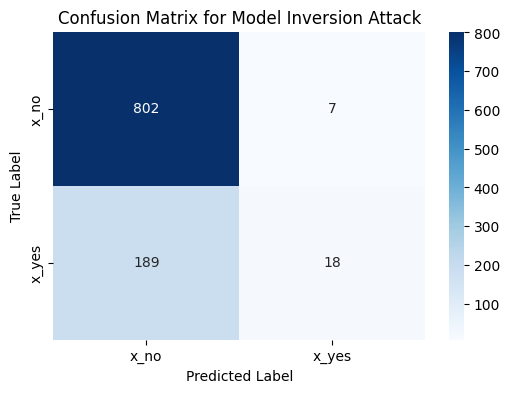

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# Secure Multi-Party Computation (MPC) Placeholder Function
def secure_mpc_computation(data, num_columns):
    data = data.copy()
    data[:, num_columns] += np.random.uniform(-0.01, 0.01, size=data[:, num_columns].shape)
    return data

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, b' ')[:16]
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# Feature Suppression Function
def feature_suppression(data, sensitive_columns):
    return np.delete(data, sensitive_columns, axis=1)  # Remove sensitive features

# Differential Privacy Function
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return np.clip(data + noise, 0, None)

# Adversarial Training Loss Function
def adversarial_training_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str)
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply Differential Privacy First
X_train_dp = add_differential_privacy_noise(X_train)

# Apply Secure MPC
X_train_secure = secure_mpc_computation(X_train_dp, num_columns=[0, 1, 2])
X_test_secure = secure_mpc_computation(X_test, num_columns=[0, 1, 2])

# Suppress Features
X_train_suppressed = feature_suppression(X_train_secure, sensitive_columns=[0, 1, 2])
X_test_suppressed = feature_suppression(X_test_secure, sensitive_columns=[0, 1, 2])

# Train target model with adversarial training loss
def train_target_model(X_train, y_train):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=adversarial_training_loss,
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return model

target_model_adversarial = train_target_model(X_train_suppressed, y_train)

# Train and evaluate inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test_suppressed, sensitive_test)
results = evaluate_inversion_model(inversion_model_adversarial, X_test_suppressed, sensitive_test, target_model_adversarial)